1.Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [345]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [346]:
from sklearn.datasets import load_diabetes

In [347]:
X, y = load_diabetes(return_X_y=True)

In [348]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=100)

In [349]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [350]:
def bias(y, z):
    return (y - z)

In [351]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [352]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [353]:
def get_fit(n_trees, max_depth, coefs, eta):
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    return trees, train_errors, test_errors

In [354]:
# Число деревьев в ансамбле
n_trees = 20

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [355]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [356]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

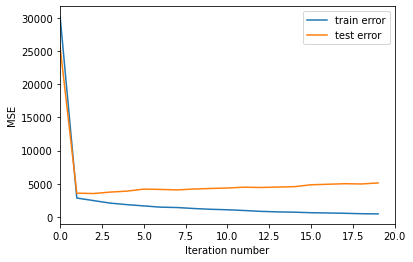

In [357]:
get_error_plot(n_trees, train_errors, test_errors)

In [366]:
errors_train = []
errors_test = []
n_trees=20
for i in range(1,n_trees): 
    n_trees = i
    trees, train_errors, test_errors= gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    errors_train.append(np.mean(train_errors))
    errors_test.append(np.mean(test_errors))

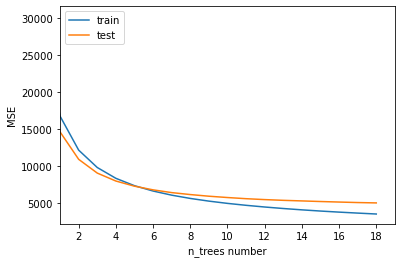

In [371]:
plt.xlabel('n_trees number')
plt.ylabel('MSE')
plt.xlim(1, n_trees)
# plt.ylim(0, n_trees)
plt.plot(list(range(n_trees)), errors_train, label='train')
plt.plot(list(range(n_trees)), errors_test, label='test')
plt.legend(loc='upper left')
    

In [372]:
errors_train = []
errors_test = []
max_depth=20
for i in range(1,max_depth): 
    max_depth = i
    trees, train_errors, test_errors= gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    errors_train.append(np.mean(train_errors))
    errors_test.append(np.mean(test_errors))
    

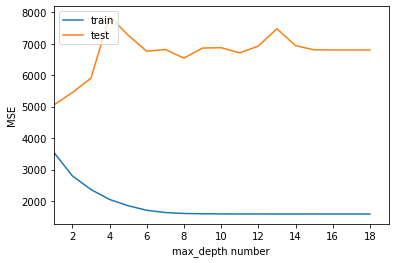

In [373]:
plt.xlabel('max_depth number')
plt.ylabel('MSE')
plt.xlim(1, max_depth)
# plt.ylim(0, n_trees)
plt.plot(list(range(max_depth)), errors_train, label='train')
plt.plot(list(range(max_depth)), errors_test, label='test')
plt.legend(loc='upper left')

In [374]:
# n_trees - С увеличением числа деревьев средняя ошибка снижается.
# max_depth - Ошибка вначале растет, потом снижается, достигая локального минимума в районе 7.

2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [375]:
np.random.seed(100)

def get_bootstrap(data, labels,d=0.5, N=1):
    n_samples = int(data.shape[0]*d)
    bootstrap = []       
    for i in range(N):
        b_data = np.zeros((n_samples,data.shape[1]))
        b_labels = np.zeros(n_samples)      
        for j in range(n_samples):
            sample_index = np.random.randint(0, data.shape[0]-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append([b_data, b_labels])
        
    return bootstrap

In [376]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            X_train_s, y_train_s=get_bootstrap(X_train, y_train)[0]
            tree.fit(X_train_s, y_train_s)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            # алгоритмы начиная со второго обучаем на сдвиг
            X_train_s, y_train_s=get_bootstrap(X_train, y_train)[0]
            target = gb_predict(X_train_s, trees, coefs, eta)
            tree.fit(X_train_s, bias(y_train_s, target))
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [377]:
# Число деревьев в ансамбле
n_trees = 50

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

def get_fit(n_trees, max_depth, coefs, eta):
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    return trees, train_errors, test_errors

In [378]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [391]:
def get_error_plot(n_trees, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
#     plt.ylim(0, n_trees)
#     plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper left')
    plt.show()

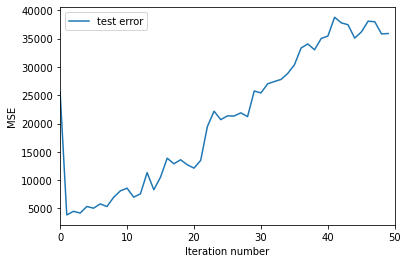

In [392]:
get_error_plot(n_trees, test_errors)